In [1]:
import pandahouse
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np
from scipy import stats

In [2]:
def get_smothed_ctr(user_likes, user_views, global_ctr, alpha):
    smothed_ctr = (user_likes + alpha * global_ctr) / (user_views + alpha)
    return smothed_ctr

In [3]:
def bootstrap(likes1, views1, likes2, views2, n_bootstrap=2000):
    poisson_bootstraps1 = stats.poisson(1).rvs(
        (n_bootstrap, len(likes1))).astype(np.int64)
    poisson_bootstraps2 = stats.poisson(1).rvs(
            (n_bootstrap, len(likes2))).astype(np.int64)    
    globalCTR1 = (poisson_bootstraps1*likes1).sum(axis=1)/(poisson_bootstraps1*views1).sum(axis=1)    
    globalCTR2 = (poisson_bootstraps2*likes2).sum(axis=1)/(poisson_bootstraps2*views2).sum(axis=1)
    return globalCTR1, globalCTR2

In [4]:
connection = {
'host': 'https://clickhouse.lab.karpov.courses',
'password': 'dpo_python_2020',
'user': 'student',
'database': 'simulator'
}

In [5]:
q = """
SELECT exp_group,
user_id,
sum(action = 'like') as likes,
sum(action = 'view') as views,
likes/views as ctr
FROM simulator_20221220.feed_actions
WHERE toDate(time) between '2022-12-02' and '2022-12-08'
and exp_group in (1,2)
GROUP BY exp_group, user_id
"""
df = pandahouse.read_clickhouse(q, connection=connection)

Для того чтобы определить какой метод анализа использовать, построим график распределения CTR в группах 1 и 2.

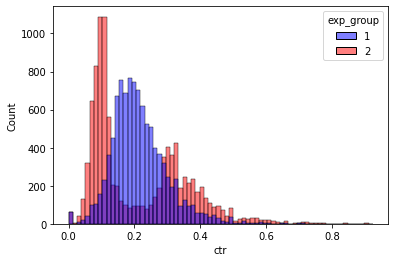

In [6]:
groups = sns.histplot(data = df, 
              x='ctr', 
              hue='exp_group', 
              palette = ['b', 'r'],
              alpha=0.5,
              kde=False)

Так как одно из распределений бимодально, можно отбросить t-тест и тест Манна-Уитни. На мой взгляд, при использовани их версий на сглаженном CTR тоже получатся не самые надежные результаты. Поэтому из известных нам методов анализа можно выбрать Пуассоновский бутстреп или t-тест и тест Манна-Уитни поверх бакетного преобразования. Начнем с бутстрепа.

In [7]:
likes1 = df[df.exp_group == 1].likes.to_numpy()
views1 = df[df.exp_group == 1].views.to_numpy()
likes2 = df[df.exp_group == 2].likes.to_numpy()
views2 = df[df.exp_group == 2].views.to_numpy()

In [8]:
ctr1, ctr2 = bootstrap(likes1, views1, likes2, views2)

Построим график распределения глобальных CTR.

<AxesSubplot:ylabel='Count'>

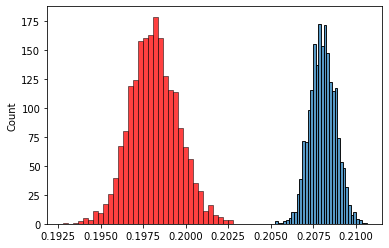

In [9]:
sns.histplot(ctr1)
sns.histplot(ctr2, color = 'r')

Можно заметить, что  данные распределения никак не пересекаются, что обозначает, что различия точно будут статистически значимыми. Также построим график разницы между глобальными CTR.

<AxesSubplot:ylabel='Count'>

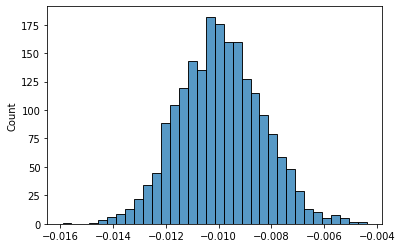

In [10]:
sns.histplot(ctr2 - ctr1)

Можно сделать вывод, что новый алгоритм статистически значимо ухудшает значения CTR.

Проведем анализ с помощью t-теста и теста Манна-Уитни поверх бакетного преобразования.

In [11]:
w = """SELECT exp_group, bucket,
    sum(likes)/sum(views) as bucket_ctr,
    quantileExact(0.9)(ctr) as ctr9
FROM (SELECT exp_group, 
        xxHash64(user_id)%50 as bucket,
        user_id,
        sum(action = 'like') as likes,
        sum(action = 'view') as views,
        likes/views as ctr
    FROM simulator_20221220.feed_actions 
    WHERE toDate(time) between '2022-12-02' and '2022-12-08'
        and exp_group in (1,2)
    GROUP BY exp_group, bucket, user_id)
GROUP BY exp_group, bucket
"""
df_bucket = pandahouse.read_clickhouse(w, connection=connection)

In [12]:
stats.mannwhitneyu(df_bucket[df_bucket.exp_group == 1].bucket_ctr, 
                   df_bucket[df_bucket.exp_group == 2].bucket_ctr, 
                   alternative = 'two-sided')

MannwhitneyuResult(statistic=1995.0, pvalue=2.859963936492646e-07)

In [13]:
stats.ttest_ind(df_bucket[df_bucket.exp_group == 1].bucket_ctr, 
                   df_bucket[df_bucket.exp_group == 2].bucket_ctr, 
                   equal_var = False)

Ttest_indResult(statistic=5.668234732053979, pvalue=3.4455951649945907e-07)

<AxesSubplot:xlabel='bucket_ctr', ylabel='Count'>

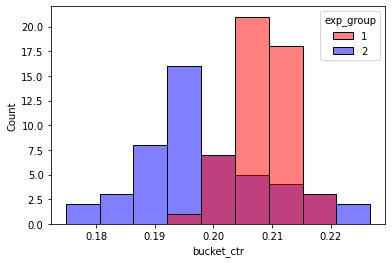

In [14]:
sns.histplot(data = df_bucket, 
              x='bucket_ctr', 
              hue='exp_group', 
              palette = ['r', 'b'],
              alpha=0.5,
              kde=False)

p-values и t-теста, и теста Манна-Уитни поверх бакетного преобразования оказались сильно меньше 0.05, что опять же говорит о статистически значимых различиях в CTR между группами 1 и 2. Учитывая график, можно сказать, что новый алгоритм работает хуже старого.

Попробуем провести другие тесты на изначальной выборке.

In [15]:
# t-тест
stats.ttest_ind(df[df.exp_group == 1].ctr,
                df[df.exp_group == 2].ctr,
                equal_var=False)

Ttest_indResult(statistic=0.7094392041270485, pvalue=0.4780623130874935)

t-тест не показывет значимых различий, которые обнаружились ранее, из-за особенностей распределений.

In [16]:
# тест Манна-Уитни
stats.mannwhitneyu(df[df.exp_group == 1].ctr, 
                   df[df.exp_group == 2].ctr,
                   alternative = 'two-sided')

MannwhitneyuResult(statistic=56601260.5, pvalue=6.0376484617779035e-56)

Тест Манна-Уитни в силу своей нулевой гипотезы, в любом случае, на распределениях такого типа показал бы значимые различия.

In [17]:
global_ctr_1 = df[df.exp_group == 1].likes.sum()/df[df.exp_group == 1].views.sum()
global_ctr_2 = df[df.exp_group == 2].likes.sum()/df[df.exp_group == 2].views.sum()

In [18]:
group1 = df[df.exp_group == 1].copy()

In [19]:
group1['smothed_ctr'] = df.apply(
    lambda x: get_smothed_ctr(x['likes'], x['views'], global_ctr_1, 5), axis=1)

<AxesSubplot:xlabel='smothed_ctr', ylabel='Count'>

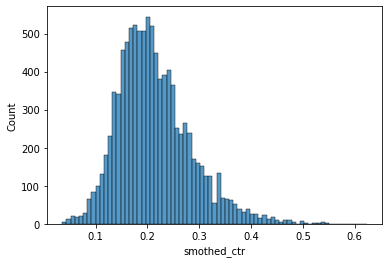

In [20]:
sns.histplot(group1.smothed_ctr, 
             kde = False)

In [21]:
group2 = df[df.exp_group == 2].copy()

In [22]:
group2['smothed_ctr'] = df.apply(
    lambda x: get_smothed_ctr(x['likes'], x['views'], global_ctr_1, 5), axis=1)

<AxesSubplot:xlabel='smothed_ctr', ylabel='Count'>

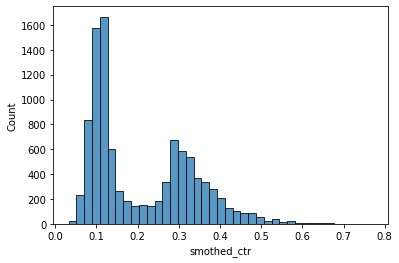

In [23]:
sns.histplot(group2.smothed_ctr, 
             kde = False)

In [24]:
stats.ttest_ind(group1.smothed_ctr,
                group2.smothed_ctr,
                equal_var=False)

Ttest_indResult(statistic=1.5383624332636343, pvalue=0.12398006885092346)

t-тест на сглаженном CTR как и предполагалось, показал хоть и меньшее p-value, однако, оно все еще больше 0.05. Так как распределение сглаженного CTR, все также является бимодальным. 

Можно предположить, что бимодальность распределения в группе с новым алгоритмом появилась в следствии разделения пользователей на 2 группы. Например, есть пользователи которых устраивает однообразный контент и пользователи которым хотелось бы разнообразия. Возможно, алгоритм некорретно работает на разных платформах.

Основываясь на результатах тестов, а также на графиках, можно порекомендовать пока не выкатывать новый алгоритм. Так как он значимо ухудшает показатель CTR в среднем на пользователей. Однако бимодальность распределения говорит о том, что нужно проанализировать результат разделения пользователей и, таким образом, улучшить алгоритм.